In [29]:
import requests
import io
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2,f_classif
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import Pipeline
from sklearn import decomposition
from mpl_toolkits.mplot3d import Axes3D

In [30]:
raw_data = requests.get("https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data").content
data = pd.read_csv(io.StringIO(raw_data.decode('utf-8')))

print(data.shape)

(8123, 23)


### Attempting to transform categorical data to numeriacal data

In [31]:
le = LabelEncoder()
le.fit(data['p'])
y_encoded = le.transform(data['p'])
y_encoded

array([0, 0, 1, ..., 0, 1, 0])

In [32]:
oe = OrdinalEncoder()
oe.fit(data.drop(data['p'],axis=1))
x_encoded = oe.transform(data.drop(data['p'],axis=1))
x_encoded

array([[5., 2., 9., ..., 3., 2., 1.],
       [0., 2., 8., ..., 3., 2., 3.],
       [5., 3., 8., ..., 2., 3., 5.],
       ...,
       [2., 2., 4., ..., 0., 1., 2.],
       [3., 3., 4., ..., 7., 4., 2.],
       [5., 2., 4., ..., 4., 1., 2.]])

### Using SelectKBest
Getting kind of suspicious results, since odor is one of the last features to be selected. The choices are not insane other than that, so might be my intuision that are wrong. Control test with PCA. If I get the same result, I give in

In [33]:
skb = SelectKBest(chi2, k=12)
x_scaled = pd.DataFrame(preprocessing.scale(x_encoded),columns=data.drop(data['p'],axis=1).columns)
skb.fit(x_encoded,y_encoded)
best_selected=skb.transform(x_scaled)
k_selected = np.array(data.drop(data['p'],axis=1).columns.values.tolist())[skb.get_support()]
k_selected

array(['s', 't', 'c', 'n.1', 'k', 'e.1', 's.1', 's.2', 'p.3', 'k.1',
       's.3', 'u'], dtype='<U3')

In [34]:
skb = SelectKBest(chi2, k=10)
dummied = pd.get_dummies(data.drop(data['p'],axis=1))
x_dummied_scaled = pd.DataFrame(preprocessing.scale(dummied),columns=dummied.columns)
skb.fit(dummied,y_encoded)
best_selected=skb.transform(x_dummied_scaled)
k_dummied_selected = np.array(dummied.columns.values.tolist())[skb.get_support()]
k_dummied_selected

array(['t_t', 'p.1_f', 'p.1_n', 'n.1_n', 'k_b', 's.1_k', 's.2_k', 'p.3_l',
       'p.3_p', 'k.1_h'], dtype='<U5')

In [35]:
pca = PCA(n_components=3)
pca.fit_transform(x_scaled)
print(pd.DataFrame(pca.components_,columns=x_scaled.columns))

          x         s         n         t       p.1         f         c  \
0  0.000698  0.105032 -0.151713 -0.347497  0.227824  0.042434  0.051198   
1  0.060780 -0.215499  0.239111 -0.278479 -0.219512  0.177439  0.351020   
2 -0.058074 -0.021139  0.083667  0.168289  0.133271  0.133087  0.375161   

        n.1         k       e.1  ...       s.2         w       w.1  p.2  \
0  0.379258 -0.387176 -0.252902  ... -0.153769  0.109147  0.102338  0.0   
1 -0.168084 -0.061483  0.271285  ... -0.385492 -0.068225 -0.072131 -0.0   
2  0.023821  0.128090  0.274958  ...  0.164864  0.445277  0.441619  0.0   

        w.2         o       p.3       k.1       s.3         u  
0  0.038740  0.048121 -0.431373  0.396425 -0.047487  0.135053  
1  0.176176 -0.069521 -0.203600 -0.254087 -0.190789 -0.025851  
2  0.127750  0.242695  0.041300  0.149429 -0.378913  0.041669  

[3 rows x 21 columns]


In [36]:
svc = SVC()
pca = PCA(n_components=3)
pipe = Pipeline([('reduce_dim',pca),('clf',svc)])
pipe.fit(x_scaled,y_encoded)
pca_res = pca.transform(x_scaled)
pca_res

array([[-2.04727371,  0.36186925,  1.27294826],
       [-1.6172362 , -0.28196298,  1.69578369],
       [-0.66973131, -0.76465389,  1.68126222],
       ...,
       [-1.16839402, -1.94630044, -1.44753318],
       [ 3.49509202, -1.15833299,  0.05160321],
       [-1.15771801, -2.36332198, -1.08812389]])

Original features (pixel index):  [0, 1, 4, 5, 9, 11, 12, 17, 25, 27, 29, 32, 35, 38, 41, 47, 49, 53, 60, 61, 63]


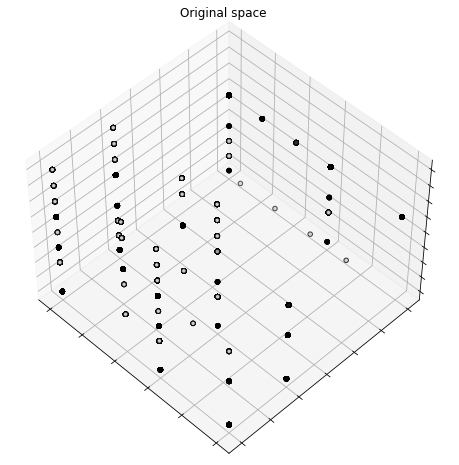

In [37]:
fig = plt.figure(1, figsize=(8, 6))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=135)

# Vis some rando features
f = sorted(np.random.permutation(64)[1:22])
print("Original features (pixel index): ",f)

ax.scatter(x_encoded[:, f[0]], x_encoded[:, f[1]], x_encoded[:, f[2]], c=y_encoded, cmap=plt.cm.nipy_spectral,
           edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_title("Original space")

plt.draw()
plt.show()

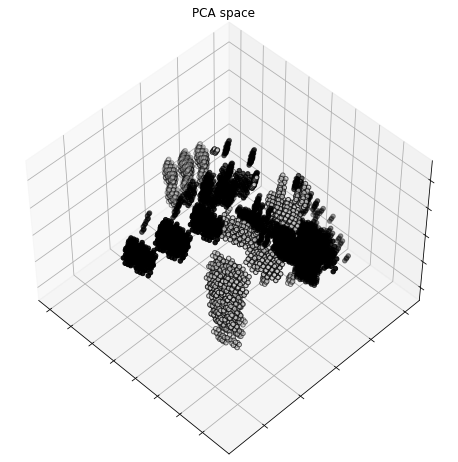

In [38]:
fig = plt.figure(2, figsize=(8, 6))
plt.clf()
ax2 = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=135)

plt.cla()

ax2.scatter(pca_res[:, 0], pca_res[:, 1], pca_res[:, 2], c=y_encoded, cmap=plt.cm.nipy_spectral,
           edgecolor='k')

ax2.w_xaxis.set_ticklabels([])
ax2.w_yaxis.set_ticklabels([])
ax2.w_zaxis.set_ticklabels([])
ax2.set_title("PCA space")

plt.draw()
plt.show()

## Spørsmål om PCA:
Forstår jeg PCA rett ved at jeg tar alle faktorene, "smelter dem sammen" (aka decomposing) basert på avhengigheter av hverandre for å lage en plot som bruker alle variablene i en tre-dimensjonal graf.
I såfall så burde PCA plotten være relativ lik som når jeg plotter med bare feauturene som var foreslått som bra i første del

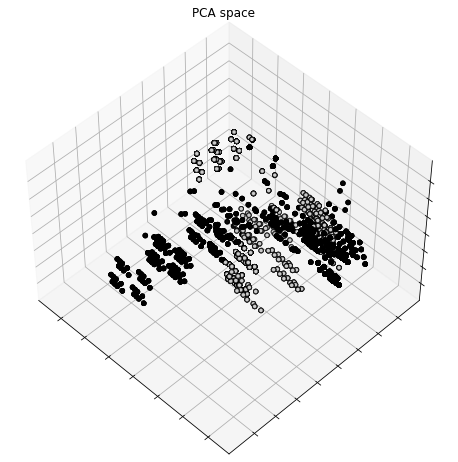

In [39]:
svc = SVC()
pca = PCA(n_components=3)
pipe = Pipeline([('reduce_dim',pca),('clf',svc)])
pipe.fit(x_scaled[k_selected],y_encoded)
pca_res = pca.transform(x_scaled[k_selected])
pca_res

fig = plt.figure(2, figsize=(8, 6))
plt.clf()
ax2 = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=135)

plt.cla()

ax2.scatter(pca_res[:, 0], pca_res[:, 1], pca_res[:, 2], c=y_encoded, cmap=plt.cm.nipy_spectral,
           edgecolor='k')

ax2.w_xaxis.set_ticklabels([])
ax2.w_yaxis.set_ticklabels([])
ax2.w_zaxis.set_ticklabels([])
ax2.set_title("PCA space")

plt.draw()
plt.show()

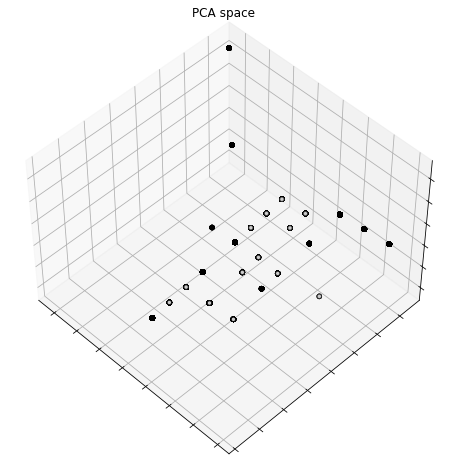

In [40]:
svc = SVC()
pca = PCA(n_components=3)
pipe = Pipeline([('reduce_dim',pca),('clf',svc)])
pipe.fit(x_scaled[['p.1','c','s.1','w.2']],y_encoded)
pca_res = pca.transform(x_scaled[['p.1','c','s.1','w.2']])
pca_res

fig = plt.figure(2, figsize=(8, 6))
plt.clf()
ax2 = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=135)

plt.cla()

ax2.scatter(pca_res[:, 0], pca_res[:, 1], pca_res[:, 2], c=y_encoded, cmap=plt.cm.nipy_spectral,
           edgecolor='k')

ax2.w_xaxis.set_ticklabels([])
ax2.w_yaxis.set_ticklabels([])
ax2.w_zaxis.set_ticklabels([])
ax2.set_title("PCA space")

plt.draw()
plt.show()

## Konklusjon:
Eeeh... Kind of...(Dette faget in a nutshell)
De svarte prikkene ser veldig like ut, men de hvite har flyttet seg en god del. Det er likheter, men kanskje ikke så dramatisk som jeg trodde. 
Det går kanskje ann å kryss referere disse grafene for å finne en optimal k, siden jo flere faktorer man kan beholde, jo mindre tap av accuracy mister man.. 
Poenget her er vel at vi skal kunne eliminere features for å gjøre kjørehastigheten på evt ML algoritme raskere, og datasettet mer håndterbart, så om man vil gjøre det på bekostning av minst mulig accuracy, så er vel dette good stuff